## Computing transport in a section

In [1]:
import numpy as np
import xarray as xr
import xorca_brokenline as bl
import cmocean as co     # for details on this colormap module see https://matplotlib.org/cmocean/
from matplotlib import colors as c
from matplotlib import pyplot as plt
from pathlib import Path
import seawater
%matplotlib inline

In [61]:
plt.rcParams['figure.figsize'] = [20, 7]
plt.rcParams.update({'font.size': 17})

global_data_path = Path("/data/iAtlantic/")
experiment_id = "VIKING20X.L46-KKG36107B"
nest_prefix = "1_"  # leave empty if global data will be used

In [62]:
# chunk sizes
chu_x = 1250
chu_y = 1250
chu_z = 1
chu_t = 1

## Start Dask client

We want to be able to control the resources used for parallel computations.

In [63]:
from dask.distributed import Client
client = Client(n_workers=1, threads_per_worker=8, memory_limit=8e9)
client

/opt/tljh/user/envs/py3_euler_brokenline/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:45289 Dashboard: /user/workshop019/proxy/43557/status,Cluster Workers: 1 Cores: 8 Memory: 8.00 GB


## Data files

In [64]:
MESH_MASK_files = list(sorted(
    (global_data_path / "mask" / experiment_id).glob(
        f"{nest_prefix}mesh_mask.nc"
    )
))

U_files = list(sorted(
    (global_data_path / "data" / experiment_id).glob(
        f"{nest_prefix}{experiment_id}_1m_2010*_*_grid_U.nc"
    )
))

V_files = list(sorted(
    (global_data_path / "data" / experiment_id).glob(
        f"{nest_prefix}{experiment_id}_1m_2010*_*_grid_V.nc"
    )
))

print(f"Found {len(MESH_MASK_files)} mesh/mask files, {len(U_files)} U files, and {len(V_files)} V files.")

Found 1 mesh/mask files, 1 U files, and 1 V files.


In [66]:
U_files

[PosixPath('/data/iAtlantic/data/VIKING20X.L46-KKG36107B/VIKING20X.L46-KKG36107B_1m_20100101_20101231_grid_U.nc')]

## Load Data

In [67]:
#Auxiliary data
ds_mesh_mask = xr.open_mfdataset(
    MESH_MASK_files,
    chunks={
        "z": chu_z,
        "y": chu_y,
        "x": chu_x
    },
    combine='by_coords')
#ds_mesh_mask = ds_mesh_mask.squeeze()  # remove degenerate time dim
#ds_mesh_mask = ds_mesh_mask.set_coords(["nav_lat", "nav_lon"])
#neccesary for xorca_brokenline to work
ds_mesh_mask = ds_mesh_mask.expand_dims('t')
ds_mesh_mask = ds_mesh_mask.rename({'nav_lev':'nav_lev_0'})
ds_mesh_mask = ds_mesh_mask.rename({'e3t_0':'e3t','e3u_0':'e3u','e3v_0':'e3v'})
ds_mesh_mask['nav_lev'] = ds_mesh_mask.nav_lev_0.isel(t=0)
ds_mesh_mask

<xarray.Dataset>
Dimensions:       (t: 1, x: 1442, y: 1021, z: 46)
Dimensions without coordinates: t, x, y, z
Data variables:
    nav_lon       (t, y, x) float32 dask.array<chunksize=(1, 1021, 1250), meta=np.ndarray>
    nav_lat       (t, y, x) float32 dask.array<chunksize=(1, 1021, 1250), meta=np.ndarray>
    nav_lev_0     (t, z) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    time_counter  (t) float64 0.0
    tmask         (t, z, y, x) int8 dask.array<chunksize=(1, 1, 1021, 1250), meta=np.ndarray>
    umask         (t, z, y, x) int8 dask.array<chunksize=(1, 1, 1021, 1250), meta=np.ndarray>
    vmask         (t, z, y, x) int8 dask.array<chunksize=(1, 1, 1021, 1250), meta=np.ndarray>
    fmask         (t, z, y, x) int8 dask.array<chunksize=(1, 1, 1021, 1250), meta=np.ndarray>
    tmaskutil     (t, y, x) int8 dask.array<chunksize=(1, 1021, 1250), meta=np.ndarray>
    umaskutil     (t, y, x) int8 dask.array<chunksize=(1, 1021, 1250), meta=np.ndarray>
    vmaskutil     (t, y, x) int8 dask.array<chunksize=(1, 1021, 1250), meta=np.ndarray>
    fmaskutil     (t, y, x) int8 dask.array<chunksize=(1, 1021, 1250), meta=np.ndarray>
    glamt         (t, y, x) float32 dask.array<chunksize=(1, 1021, 1250), meta=np.ndarray>
    glamu         (t, y, x) float32 dask.array<chunksize=(1, 1021, 1250), meta=np.ndarray>
    glamv         (t, y, x) float32 dask.array<chunksize=(1, 1021, 1250), meta=np.ndarray>
    glamf         (t, y, x) float32 dask.array<chunksize=(1, 1021, 1250), meta=np.ndarray>
    gphit         (t, y, x) float32 dask.array<chunksize=(1, 1021, 1250), meta=np.ndarray>
    gphiu         (t, y, x) float32 dask.array<chunksize=(1, 1021, 1250), meta=np.ndarray>
    gphiv         (t, y, x) float32 dask.array<chunksize=(1, 1021, 1250), meta=np.ndarray>
    gphif         (t, y, x) float32 dask.array<chunksize=(1, 1021, 1250), meta=np.ndarray>
    e1t           (t, y, x) float64 dask.array<chunksize=(1, 1021, 1250), meta=np.ndarray>
    e1u           (t, y, x) float64 dask.array<chunksize=(1, 1021, 1250), meta=np.ndarray>
    e1v           (t, y, x) float64 dask.array<chunksize=(1, 1021, 1250), meta=np.ndarray>
    e1f           (t, y, x) float64 dask.array<chunksize=(1, 1021, 1250), meta=np.ndarray>
    e2t           (t, y, x) float64 dask.array<chunksize=(1, 1021, 1250), meta=np.ndarray>
    e2u           (t, y, x) float64 dask.array<chunksize=(1, 1021, 1250), meta=np.ndarray>
    e2v           (t, y, x) float64 dask.array<chunksize=(1, 1021, 1250), meta=np.ndarray>
    e2f           (t, y, x) float64 dask.array<chunksize=(1, 1021, 1250), meta=np.ndarray>
    ff            (t, y, x) float64 dask.array<chunksize=(1, 1021, 1250), meta=np.ndarray>
    mbathy        (t, y, x) int16 dask.array<chunksize=(1, 1021, 1250), meta=np.ndarray>
    misf          (t, y, x) int16 dask.array<chunksize=(1, 1021, 1250), meta=np.ndarray>
    isfdraft      (t, y, x) float32 dask.array<chunksize=(1, 1021, 1250), meta=np.ndarray>
    e3t           (t, z, y, x) float64 dask.array<chunksize=(1, 1, 1021, 1250), meta=np.ndarray>
    e3u           (t, z, y, x) float64 dask.array<chunksize=(1, 1, 1021, 1250), meta=np.ndarray>
    e3v           (t, z, y, x) float64 dask.array<chunksize=(1, 1, 1021, 1250), meta=np.ndarray>
    e3w_0         (t, z, y, x) float64 dask.array<chunksize=(1, 1, 1021, 1250), meta=np.ndarray>
    gdept_0       (t, z, y, x) float32 dask.array<chunksize=(1, 1, 1021, 1250), meta=np.ndarray>
    gdepu         (t, z, y, x) float32 dask.array<chunksize=(1, 1, 1021, 1250), meta=np.ndarray>
    gdepv         (t, z, y, x) float32 dask.array<chunksize=(1, 1, 1021, 1250), meta=np.ndarray>
    gdepw_0       (t, z, y, x) float32 dask.array<chunksize=(1, 1, 1021, 1250), meta=np.ndarray>
    gdept_1d      (t, z) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    e3t_1d        (t, z) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    e3w_1d        (t, z) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>
    depthw        (t, 

In [68]:
ds_U = xr.open_mfdataset(
    U_files,
    chunks={
        "time_counter": chu_t,
        "depthu": chu_z,
        "y": chu_y,
        "x": chu_x
    },
    combine='by_coords')

In [69]:
ds_V = xr.open_mfdataset(
    V_files,
    chunks={
        "time_counter": chu_t,
        "depthv": chu_z,
        "y": chu_y,
        "x": chu_x
    },
    combine='by_coords')

distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Restarting worker
/opt/tljh/user/envs/py3_euler_brokenline/lib/python3.7/multiprocessing/semaphore_tracker.py:55: UserWarning: semaphore_tracker: process died unexpectedly, relaunching.  Some semaphores might leak.
  warnings.warn('semaphore_tracker: process died unexpectedly, '
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Work

(array([1.60000000e+01, 8.00000000e+00, 6.00000000e+00, 5.00000000e+00,
        8.00000000e+00, 3.70000000e+01, 1.76300000e+03, 8.12688306e+08,
        9.34600000e+03, 1.69000000e+02]),
 array([-19.409231 , -16.826302 , -14.243372 , -11.660443 ,  -9.077514 ,
         -6.494584 ,  -3.911655 ,  -1.3287256,   1.2542038,   3.8371332,
          6.4200625], dtype=float32),
 <a list of 10 Patch objects>)

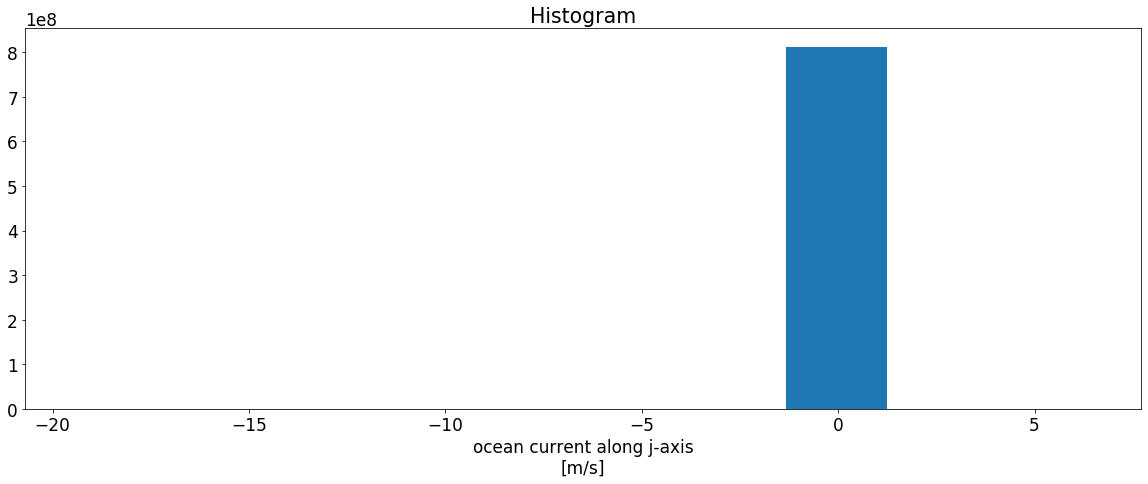

In [73]:
ds_V.isel(time_counter=10,depthv=0).vomecrty.plot()

In [78]:
ds_U.nav_lon.min().values

array(-179.9991, dtype=float32)

## Define section

In [11]:
lon_sa_min=-50
lon_sa_max= 15
lat_sa_min=-32.5
lat_sa_max=-30

lonv = ds_U.nav_lon.isel(y=0).values
ilonv_min = (np.abs(lonv-lon_sa_min)).argmin()
ilonv_max = (np.abs(lonv-lon_sa_max)).argmin()

latv = ds_U.nav_lat.isel(x=0).values
ilatv_min = (np.abs(latv-lat_sa_min)).argmin()
ilatv_max = (np.abs(latv-lat_sa_max)).argmin()

print('ilon:',ilonv_min,ilonv_max)
print('ilat:',ilatv_min,ilatv_max)

ilon: 968 2268
ilat: 36 95


In [12]:
ji_pairs = [
    (ilatv_min, ilonv_min),
    (ilatv_max,ilonv_max)
]

In [27]:
fmask = ds_mesh_mask['fmask'].isel(z=0,t=0)

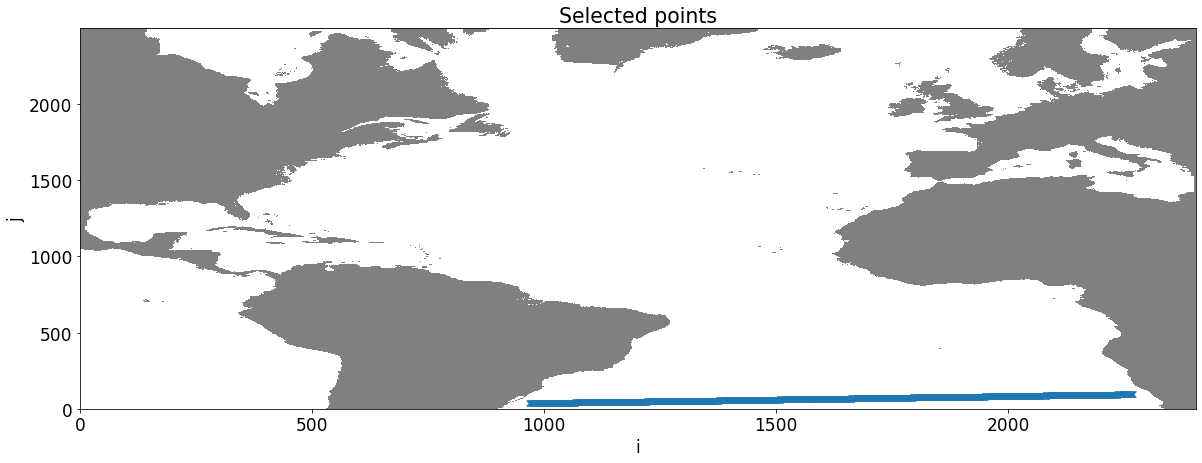

In [28]:
fmask.plot(cmap=c.ListedColormap(['gray','white']),add_colorbar=0)
plt.plot(ii,jj,'x')

plt.ylabel("j")
plt.xlabel("i")
plt.title('Selected points');

## Extract Section
bl.shift_grids() interpolates all variables onto the u- and v-points, drops unnecessary coordinate labels and variables and renames depth dimension. <br>
select_section() selects the section defined by ji from gridU_processed and gridV_processed and returns a section.


In [29]:
bl.select_section?

Signature:
bl.select_section(
    ij,
    gridU,
    gridV,
    mesh_hgr=None,
    mesh_zgr=None,
    mask=None,
)
Docstring:
Form a section by selecting quantities at U or V, depending on the
    orientation of each segment.
    We define velocities and transports, that go to the right of the
    progression of the section, as positiv.
    This means that the sign of the velocities depends on the order of the
    input points.
    For each leg, velocities are converted as follows:
        i0_leg < i1_leg -> V*(-1)
        j0_leg > j1_leg -> U*(-1)

Parameters
----------
ij : Iterator of tuples.
    Iterator of n tuples of ji-coordinates defining the secion.
gridU : xarray.Dataset
    Dataset of shape (t,z,y,x) holding variables at U-point.
    Use dataset returned by broken_line.reduce_dataset()
gridV : xarray.Dataset
    Dataset of shape (t,z,y,x) holding variables at V-point.
    Use dataset returned by broken_line.reduce_dataset()
mesh_hgr : xarray.Dataset, optional
    Dataset of 

In [43]:
ji = bl.section_indices(ji_pairs=ji_pairs)
gridU_processed, gridV_processed = bl.shift_grids(gridU=ds_U, gridV=ds_V)
section = bl.select_section(
    ji,gridU_processed,gridV_processed,ds_mesh_mask,ds_mesh_mask,ds_mesh_mask
    ).compute()

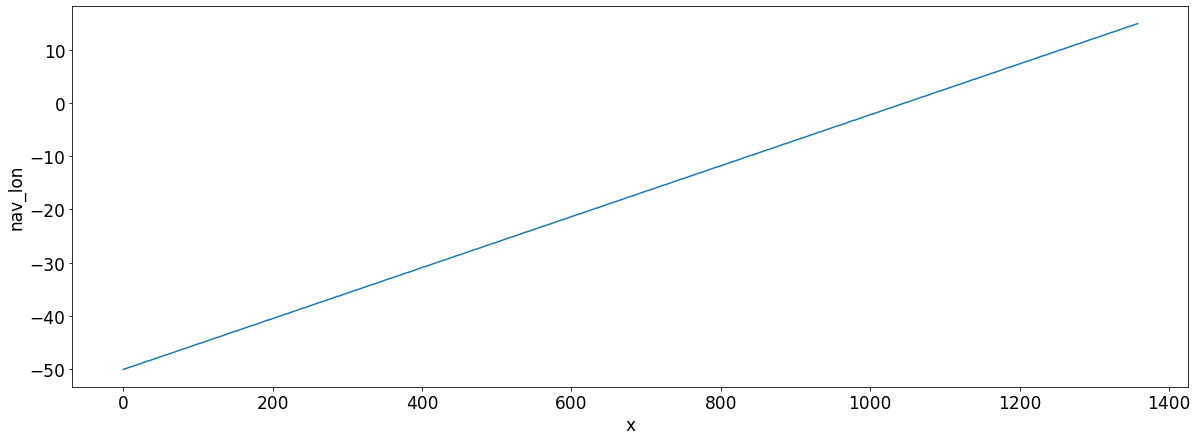

In [47]:
ji = bl.section_indices(ji_pairs=ji_pairs)
#lij=list(ji)
#len(lij)

lji = [tuple(ji2) for ji2 in ji]
sali=np.array(lji)

#nav_lat       (t, y, x) 
lon1=ds_mesh_mask.nav_lon.isel(t=0,y=sali[:,0],x=sali[:,1])
lon2=lon1.isel(y=0)[:-1]
lon2.plot()

In [44]:
section

<xarray.Dataset>
Dimensions:       (c: 1359, time_counter: 12, z: 46)
Coordinates:
  * c             (c) float64 4.69e+03 9.38e+03 ... 6.456e+06 6.461e+06
  * z             (z) float64 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
  * time_counter  (time_counter) datetime64[ns] 2010-01-16T12:00:00 ... 2010-12-16T12:00:00
Data variables:
    u_normal      (time_counter, z, c) float64 0.1895 0.1634 0.1487 ... 0.0 0.0
    dx            (c) float64 4.69e+03 4.69e+03 4.69e+03 ... 4.817e+03 4.817e+03
    dz            (z, c) float64 6.191 6.191 6.191 6.191 ... 250.4 250.4 250.4
    mask          (z, c) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0

In [114]:
section

<xarray.Dataset>
Dimensions:       (c: 1359, time_counter: 12, z: 46)
Coordinates:
  * c             (c) float64 4.69e+03 9.38e+03 ... 6.456e+06 6.461e+06
  * z             (z) float64 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
  * time_counter  (time_counter) datetime64[ns] 2010-01-16T12:00:00 ... 2010-12-16T12:00:00
Data variables:
    u_normal      (time_counter, z, c) float64 0.1895 0.1634 0.1487 ... 0.0 0.0
    dx            (c) float64 4.69e+03 4.69e+03 4.69e+03 ... 4.817e+03 4.817e+03
    dz            (z, c) float64 6.191 6.191 6.191 6.191 ... 250.4 250.4 250.4
    mask          (z, c) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0

Section includes the velocity normal to the section (either U or V, depending on the orientation of each segment), the length and depth of each segment and a land-sea mask variable. 

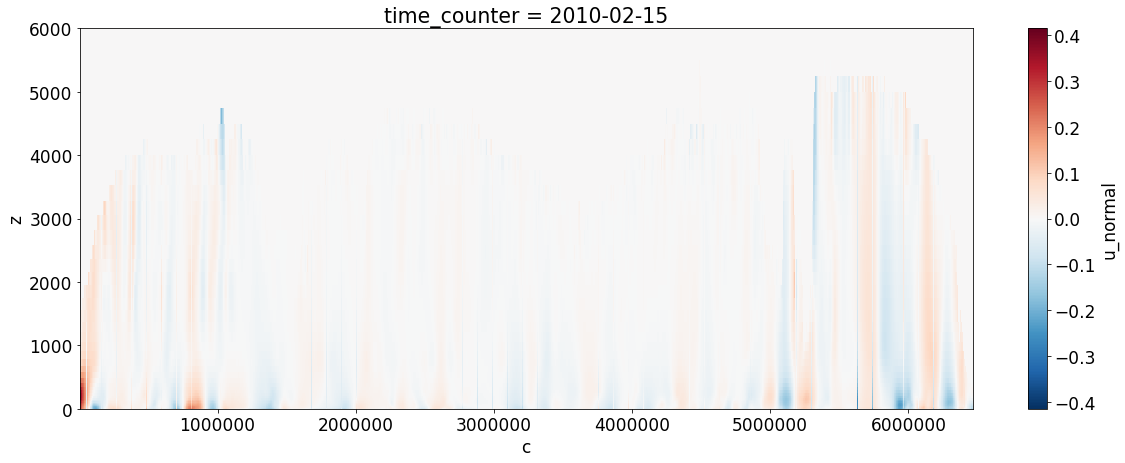

In [53]:
section['u_normal'].isel(time_counter=1).plot()

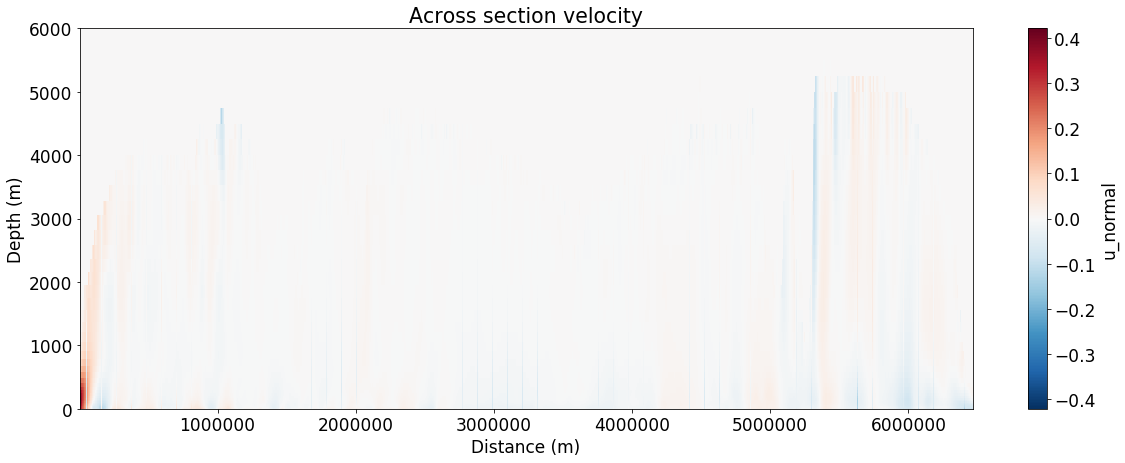

In [48]:
section['u_normal'].mean('time_counter').plot()
#section['mask'].where(section['mask']==0).plot(cmap=c.ListedColormap(['gray']),add_colorbar=0)
plt.ylabel("Depth (m)")
plt.xlabel("Distance (m)")
plt.title("Across section velocity");

## Volume Transport

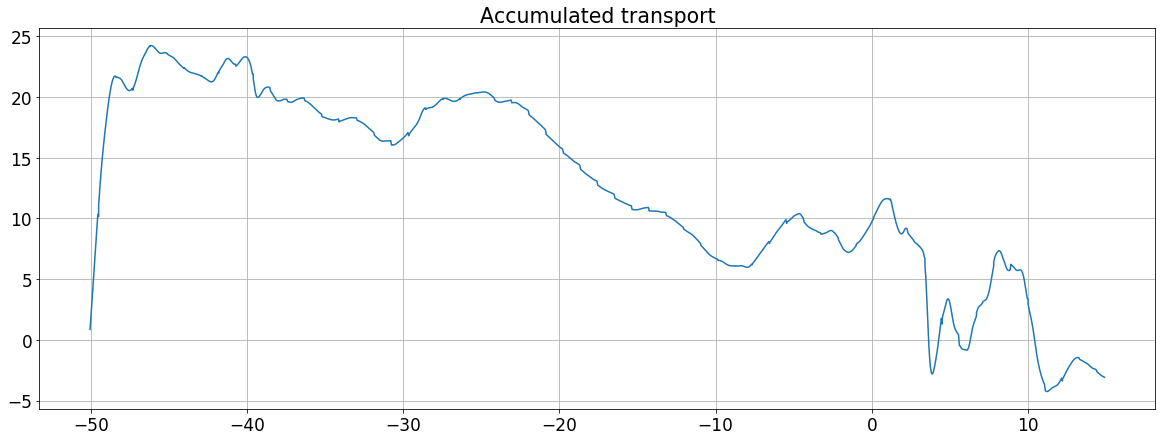

In [60]:
transport = bl.calculate_transport(section)
transport.values()

Int1 = section.u_normal*section.dx*section.dz/1e6
Inty2 = Int1.sum('z').cumsum('c').mean(dim = "time_counter")

fig, ax = plt.subplots()
ax.plot(lon2,Inty2)
plt.grid()
plt.title('Accumulated transport');

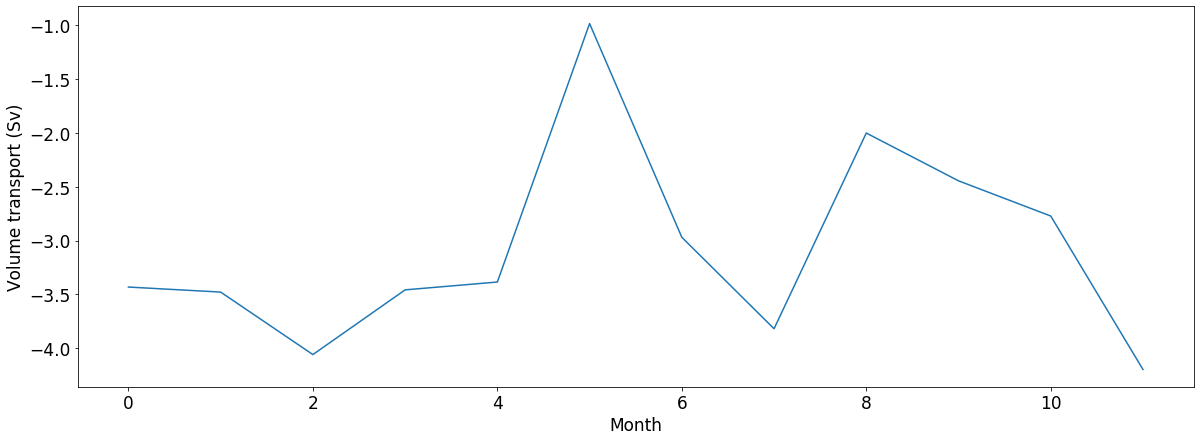

In [50]:
plt.plot(transport['trsp'])
plt.ylabel("Volume transport (Sv)");
plt.xlabel("Month");